In [1]:
%reload_ext autoreload
%autoreload 2
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import sys
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/analysisTools/")
from analysisTools import Analyzer
from analysisTools import fileAnalyzer
from analysisTools import loadSchema
import analysisTools as tools
import analysisSubroutines as routines
import importlib
import coffea.util as util
import time
import json

In [2]:
test = Analyzer("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/configs/sample_configs/test_sig.json",
                "/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/configs/histo_configs/SR_studies.py",
                "/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/configs/cut_configs/base_cuts.py",
                )

In [3]:
t1 = time.time()
out = test.process(execr='futures')
t2 = time.time()
print(t2-t1)

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [ 0:00:11 < 0:00:00 | 0.8  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [ 0:00:11 < 0:00:00 | ?   merges/s ]

13.035608768463135


In [5]:
util.save(out,"signal_histos.coffea")

In [44]:
cf = out[0]['cutflow']
cuts = out[0]['cutDesc'].keys

In [43]:
import re
def signalMatch(signal):
    p = re.search("_Mchi-(\d+p\d)_dMchi-(\d+p\d)_ctau-(\d+)",signal)
    m, dm, ct = p.group(1), p.group(2), p.group(3)
    m = float(m.replace("p","."))
    dm = float(m.replace("p","."))
    ct = float(ct)

In [48]:
sorted([4,1,3,2])

[1, 2, 3, 4]

In [4]:
f0 = test.sample_locs['sig_2018_Mchi-108p0_dMchi-36p0_ctau-1'][0]
events = loadSchema(f0)
print(len(events))

5127


In [6]:
routines.selectGoodElesAndVertices(events)

events.__setitem__("nGoodVtx",ak.count(events.good_RRvtx.vxy,axis=1) + 
                                ak.count(events.good_LRvtx.vxy,axis=1) +
                                ak.count(events.good_LLvtx.vxy,axis=1))
events = events[events.nGoodVtx > 0]

# pre-computing quantities for cuts
events.__setitem__("JetMETdPhi",tools.deltaPhi(events.PFJet.corrPhi,events.PFMET.correctedPhi))

In [9]:
events.JetMETdPhi[:,0]

ValueError: in ListOffsetArray64 attempting to get 0, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/cpu-kernels/awkward_NumpyArray_getitem_next_at.cpp#L21)

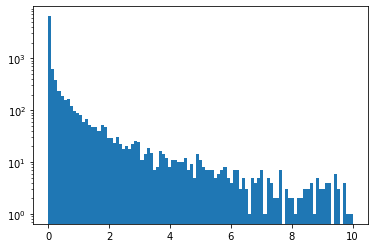

In [10]:
h2 = plt.hist(ak.flatten(events.Electron.trkRelIso),bins=np.linspace(0,10,100))
plt.yscale('log')

In [55]:
import numba as nb

a1 = np.array([0,1,2])
a2 = np.array([[0,1],[2,3],[2,4]])

@nb.guvectorize("void(int64,int64[:],boolean)","(),(n)->()")
def f(a,b,c):
    print(a)
    print(b)
    for ib in b:
        print(ib)
        c = a==ib
    print("---")

In [256]:
@nb.vectorize(['int64(int64,int64)'])
def f(a,b):
    return (1<<a) | (1<<b)

In [209]:
t1

<Array [[0], [0, 1]] type='2 * var * int64'>

In [ ]:
samples = "/uscms_data/d3/sbrightt/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/configs/sample_configs/signal_2018_aEM.json"
histos = "/uscms_data/d3/sbrightt/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/configs/histo_configs/histoList.json"
with open(samples,"r") as f:
    dsamp = json.load(f)
flist = dsamp[8:12]

In [ ]:
az = Analyzer(flist,histos)
histos = az.process()

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20/20 [ 0:01:06 < 0:00:00 | 0.3 chunk/s ]

(0.0, 1.0)

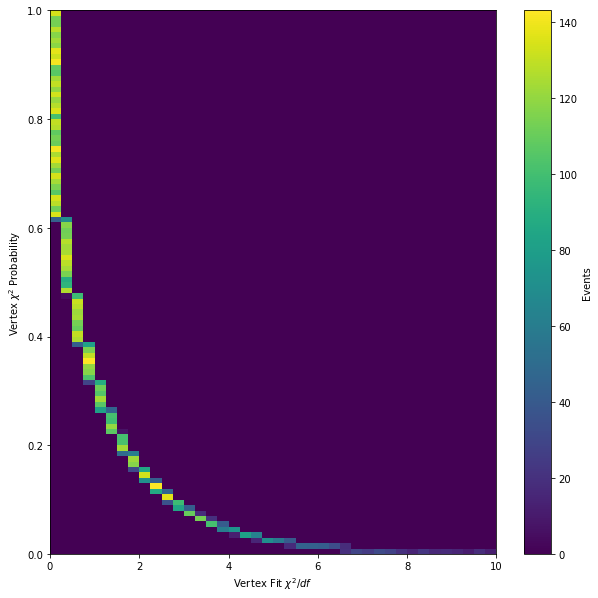

In [ ]:
h = histos['vtx_qual_genMatchByEle']
plt.figure(figsize=(10,10))
h = h.integrate('set',int_range='RL').sum('integrate',int_range='all').integrate('type',int_range='Reg-Reg')
hist.plot2d(h,xaxis='chi2',ax=plt.gca())
plt.xlim([0,10])
plt.ylim([0,1])

/uscms_data/d3/sbrightt/miniforge/envs/coffea/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/sbrightt/miniforge/envs/coffea/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/sbrightt/miniforge/envs/coffea/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/sbrightt/miniforge/envs/coffea/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/sbrightt/miniforge/envs/coffea/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: inv

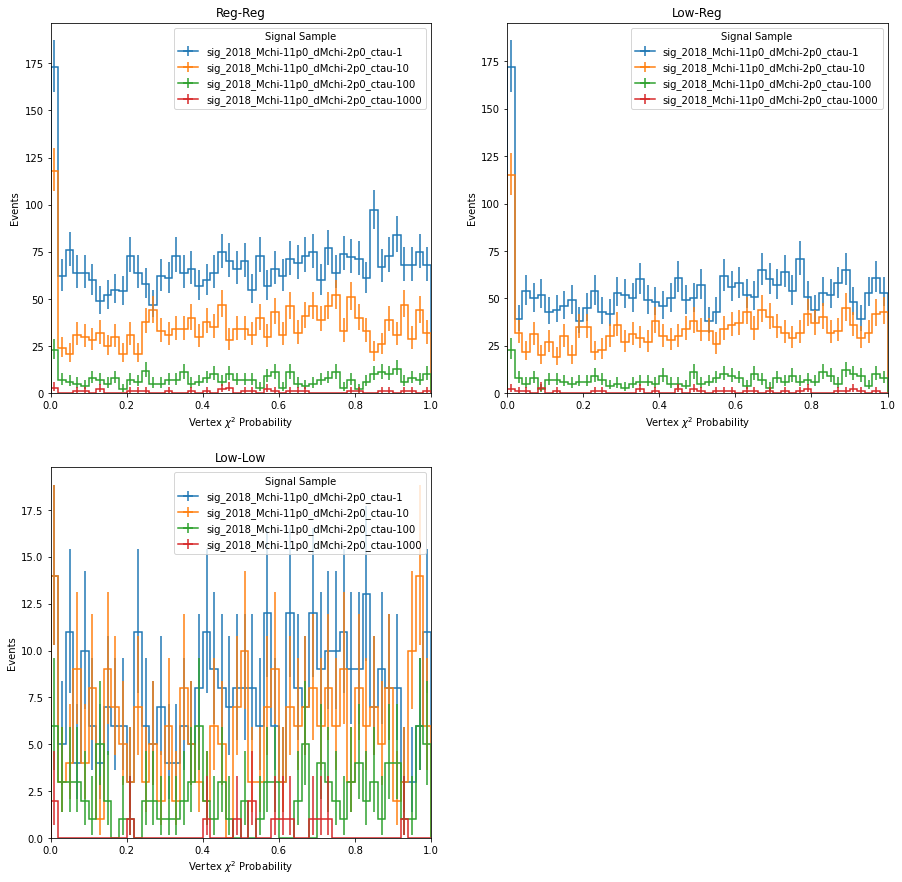

In [ ]:
h = histos['vtx_qual_genMatchByEle']
plt.figure(figsize=(15,15))
types = ['Reg-Reg','Low-Reg','Low-Low']
for i,tp in enumerate(types):
    ax = plt.subplot(2,2,i+1)
    ht = h.integrate('set',int_range='RL').sum('chi2',overflow='all').integrate('type',int_range=tp).rebin('prob',2)
    hist.plot1d(ht,ax=ax,overlay='sample',density=False)
    plt.title(tp)
    plt.xlim([0,1])

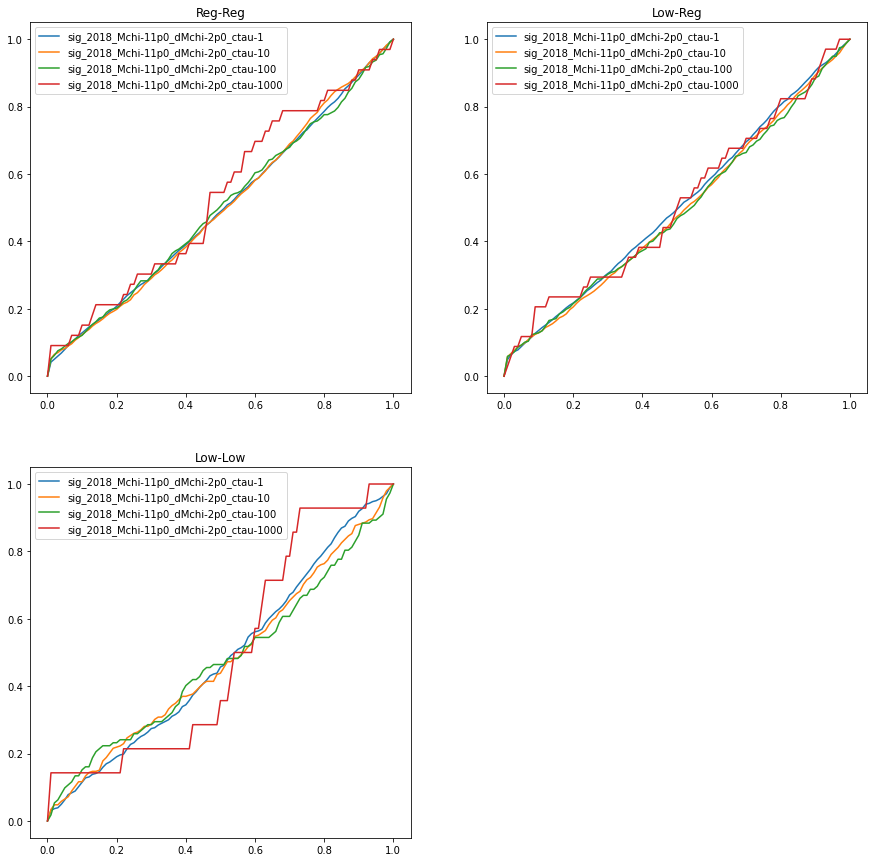

In [65]:
h = histos['vtx_qual_genMatchByEle']
plt.figure(figsize=(15,15))
types = ['Reg-Reg','Low-Reg','Low-Low']
for i,tp in enumerate(types):
    ax = plt.subplot(2,2,i+1)
    ht = h.integrate('set',int_range='RL').sum('chi2',overflow='all').integrate('type',int_range=tp)
    samples = ht.axis('sample').identifiers()
    for samp in samples:
        t = ht.integrate('sample',int_range=samp)
        xvals = t.axes()[0].edges()
        cts = np.insert(t.values()[()],0,0)
        tot = np.sum(cts)
        ax.plot(xvals,np.cumsum(cts)/tot,label=samp)
    plt.legend(loc='upper left')
    plt.title(tp)

In [44]:
t = h.integrate('set',int_range='RL').sum('chi2',overflow='all').integrate('type',int_range='Reg-Reg').integrate('sample',int_range='sig_2018_Mchi-11p0_dMchi-2p0_ctau-1')
t.axes()[0].edges()[-1]

1.0

In [57]:
cts = t.values()[()]

In [61]:
print(np.insert(cts,0,0))
print(cts)

[  0. 143.  30.  31.  31.  37.  39.  29.  35.  38.  26.  30.  30.  24.
  25.  26.  26.  24.  31.  25.  29.  38.  35.  36.  28.  28.  30.  26.
  21.  23.  39.  31.  30.  38.  35.  30.  34.  33.  33.  27.  30.  32.
  28.  35.  29.  42.  33.  28.  42.  37.  29.  31.  39.  20.  35.  40.
  33.  28.  29.  41.  25.  21.  41.  37.  34.  39.  30.  34.  39.  37.
  38.  27.  33.  38.  39.  23.  41.  38.  36.  36.  36.  39.  32.  26.
  35.  45.  52.  31.  36.  37.  36.  40.  44.  39.  29.  36.  32.  44.
  31.  40.  28.]
[143.  30.  31.  31.  37.  39.  29.  35.  38.  26.  30.  30.  24.  25.
  26.  26.  24.  31.  25.  29.  38.  35.  36.  28.  28.  30.  26.  21.
  23.  39.  31.  30.  38.  35.  30.  34.  33.  33.  27.  30.  32.  28.
  35.  29.  42.  33.  28.  42.  37.  29.  31.  39.  20.  35.  40.  33.
  28.  29.  41.  25.  21.  41.  37.  34.  39.  30.  34.  39.  37.  38.
  27.  33.  38.  39.  23.  41.  38.  36.  36.  36.  39.  32.  26.  35.
  45.  52.  31.  36.  37.  36.  40.  44.  39.  29.  36.  32.